In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
import scipy as sp
import seaborn as sns
from lifelines import KaplanMeierFitter
from lifelines import WeibullFitter
from scipy.stats import weibull_min
from wordcloud import WordCloud, STOPWORDS


In [2]:
path = 'C:/Users/kobi_z/Documents/Data Analysis/RMA/Reliability Calculation/JET RMA1.csv'
df = pd.read_csv(path, header=0)

In [3]:
df=df.drop_duplicates()
today=date.today()


df['Ship Date'] = pd.to_datetime(df['Ship Date'],errors='coerce')

df['Order/RMA Date'] = pd.to_datetime(df['Order/RMA Date'],errors='coerce')

today.strftime("%d/%m/%Y")
df['today']=today
df['today'] = pd.to_datetime(df['today'])


In [4]:
df['Lifespan']=np.where(df['Serial']!=df['Serial'].shift(-1), df['today']-df['Ship Date'],df['Order/RMA Date'].shift(-1)-df['Ship Date'])
df['Censor']=np.where(df['Serial']!=df['Serial'].shift(-1),0,1)


In [5]:
df['Lifespan']=df['Lifespan'].dt.days.astype('float')

In [6]:
df=df.dropna(subset=["Lifespan"], axis=0)
df=df[df['Lifespan']>0]

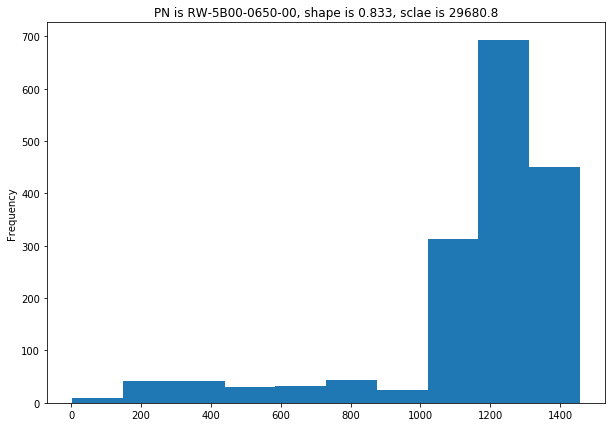

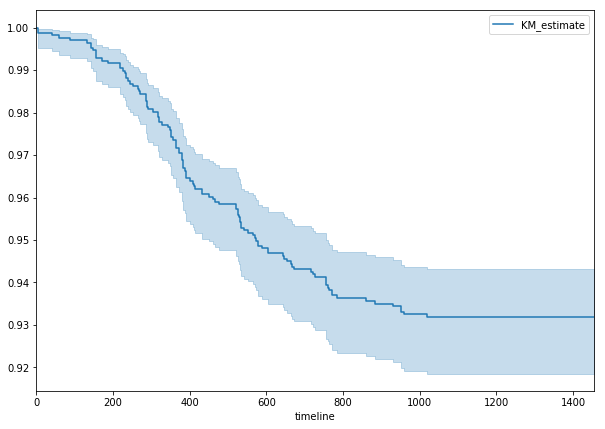

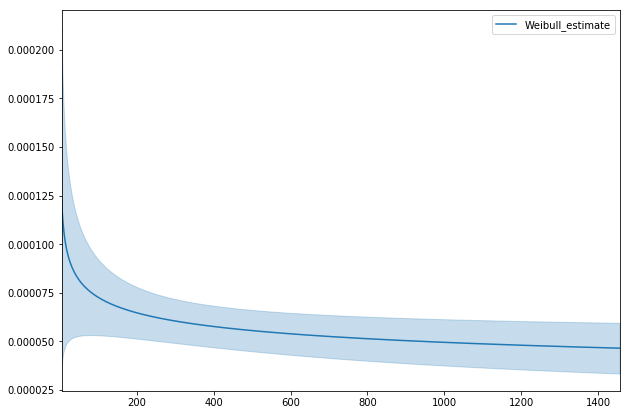

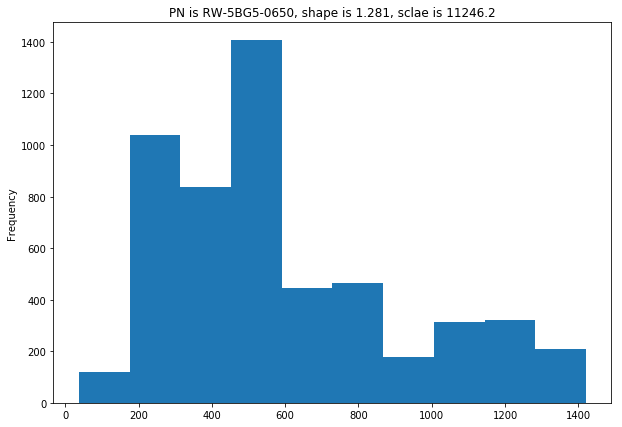

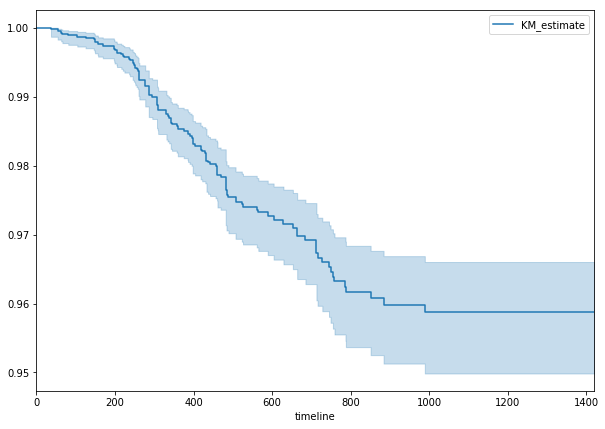

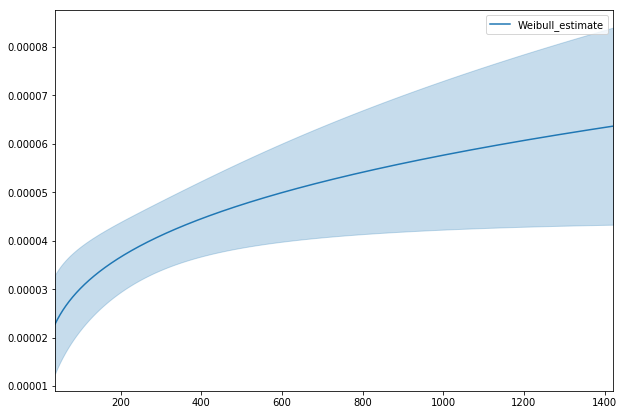

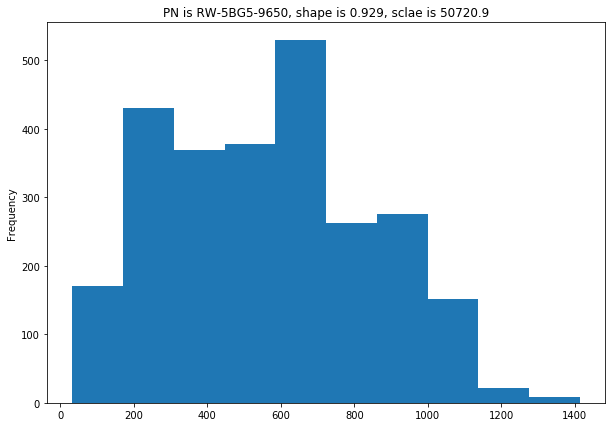

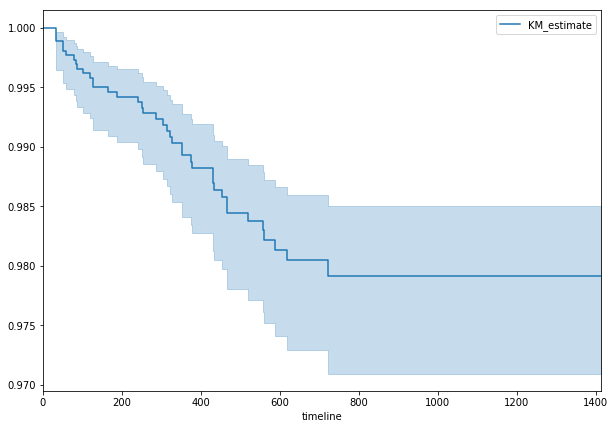

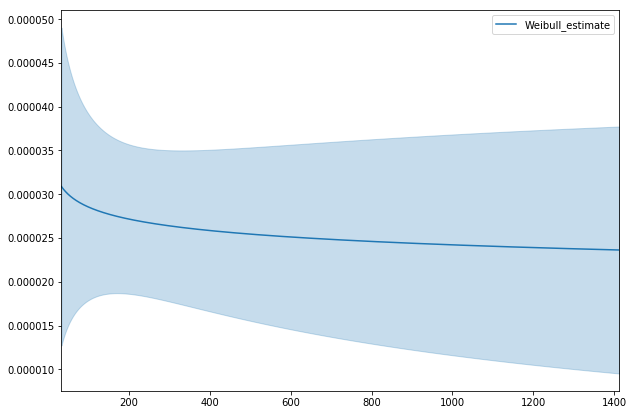

In [7]:
Results=[]
for pn in df['Part'].unique():
    df_pn=df[df['Part']==pn]
    kmf=KaplanMeierFitter()
    fig = plt.figure()
    T=df_pn['Lifespan']
    C=df_pn['Censor']
    wf = WeibullFitter().fit(T, C)
    shape=round(wf.rho_,3)
    scale=round(wf.lambda_,1)
    mtbf=round(wf.median_,1)
    mtbf_y=round(mtbf/365,1)
    ten_year=round(1-wf.cumulative_density_at_times(3650)[3650],2)
    ax1=df_pn['Lifespan'].plot(kind='hist',figsize=(10,7))
    ax1.set_title('PN is {}, shape is {}, sclae is {}'.format(pn,shape,scale))
    
    kmf.fit(T,C)
    kmf.plot(figsize=(10,7))
    
    wf.plot_hazard(figsize=(10,7))
    
    Results.append([pn,shape,scale,mtbf,mtbf_y,ten_year])

In [8]:
df_results=pd.DataFrame(Results,columns=['PN','Shape','Scale','MTBF-d','MTBF-y','Survive 10y'])

In [9]:
df_results

,PN,Shape,Scale,MTBF-d,MTBF-y,Survive 10y
0,RW-5B00-0650-00,0.833,29680.8,19119.5,52.4,0.84
1,RW-5BG5-0650,1.281,11246.2,8448.8,23.1,0.79
2,RW-5BG5-9650,0.929,50720.9,34182.9,93.7,0.92
